In [2]:


import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mekde/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mekde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mekde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

class NewsStockCorrelation:
    def __init__(self, news_df, stock_df, news_date_col='date', stock_date_col='Date'):
        self.news = news_df.copy()
        self.stock = stock_df.copy()
        self.news_date_col = news_date_col
        self.stock_date_col = stock_date_col
        self.daily_sentiment = None
        self.daily_returns = None
        self.merged = None

        # Convert news dates to datetime
        # Automatically parse dates and handle tz-naive and tz-aware datetimes
        self.news[self.news_date_col] = pd.to_datetime(
            self.news[self.news_date_col], utc=True, errors='coerce'
        )

        self.news['date_only'] = self.news[self.news_date_col].dt.date

        # Convert stock dates to datetime and set index
        self.stock[self.stock_date_col] = pd.to_datetime(self.stock[self.stock_date_col])
        self.stock.set_index(self.stock_date_col, inplace=True)
        self.stock.sort_index(inplace=True)

    # -----------------------
    # Sentiment Analysis
    # -----------------------
    def compute_headline_sentiment(self, method='vader'):
        if method == 'vader':
            sia = SentimentIntensityAnalyzer()
            self.news['sentiment_compound'] = self.news['headline'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
        elif method == 'textblob':
            self.news['sentiment_compound'] = self.news['headline'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
        else:
            raise ValueError("Unsupported sentiment method. Choose 'vader' or 'textblob'.")
        return self.news

    # -----------------------
    # Aggregate daily sentiment
    # -----------------------
    def aggregate_daily_sentiment(self):
        if 'sentiment_compound' not in self.news.columns:
            raise RuntimeError("Run compute_headline_sentiment() first.")
        grouped = self.news.groupby('date_only')['sentiment_compound'].mean().to_frame('sentiment_mean')
        grouped.index = pd.to_datetime(grouped.index)

        # Make timezone UTC-aware to prevent merge issues
        if grouped.index.tz is None:
            grouped.index = grouped.index.tz_localize('UTC')
        else:
            grouped.index = grouped.index.tz_convert('UTC')

        self.daily_sentiment = grouped.sort_index()
        return self.daily_sentiment

    # -----------------------
    # Compute daily returns
    # -----------------------
    def compute_daily_returns(self):
        self.daily_returns = self.stock['Close'].pct_change().to_frame('returns')
        # Ensure UTC timezone for alignment
        if self.daily_returns.index.tz is None:
            self.daily_returns.index = self.daily_returns.index.tz_localize('UTC')
        else:
            self.daily_returns.index = self.daily_returns.index.tz_convert('UTC')
        return self.daily_returns

    # -----------------------
    # Merge sentiment and returns
    # -----------------------
    def merge_sentiment_and_returns(self, shift_news_to_next_trading_day=False):
        if self.daily_sentiment is None or self.daily_returns is None:
            raise RuntimeError("Run aggregate_daily_sentiment() and compute_daily_returns() first.")

        sent = self.daily_sentiment.copy()
        ret = self.daily_returns.copy()

        if shift_news_to_next_trading_day:
            sent.index = sent.index + pd.offsets.BDay(1)

        # Ensure both indices are UTC-aware
        if getattr(sent.index, 'tz', None) is None:
            sent.index = sent.index.tz_localize('UTC')
        else:
            sent.index = sent.index.tz_convert('UTC')

        if getattr(ret.index, 'tz', None) is None:
            ret.index = ret.index.tz_localize('UTC')
        else:
            ret.index = ret.index.tz_convert('UTC')

        self.merged = pd.merge(ret, sent, left_index=True, right_index=True, how='inner').sort_index()
        return self.merged

    # -----------------------
    # Compute correlation
    # -----------------------
    def compute_correlation(self):
        if self.merged is None:
            raise RuntimeError("Run merge_sentiment_and_returns() first.")
        corr = self.merged['returns'].corr(self.merged['sentiment_mean'])
        return corr

    # -----------------------
    # Full pipeline
    # -----------------------
    def run_full_pipeline(self, headline_col='headline', shift_news_to_next_trading_day=True, sentiment_method='vader'):
        self.compute_headline_sentiment(method=sentiment_method)
        self.aggregate_daily_sentiment()
        self.compute_daily_returns()
        self.merge_sentiment_and_returns(shift_news_to_next_trading_day=shift_news_to_next_trading_day)
        return self.compute_correlation()

    # -----------------------
    # Plotting functions
    # -----------------------
    def plot_sentiment_and_returns(self):
        if self.merged is None:
            raise RuntimeError("Run merge_sentiment_and_returns() first.")
        plt.figure(figsize=(12,6))
        plt.plot(self.merged.index, self.merged['sentiment_mean'], label='Daily Sentiment')
        plt.plot(self.merged.index, self.merged['returns'], label='Daily Returns')
        plt.legend()
        plt.title('Daily Sentiment vs Returns')
        plt.show()

    def scatter_and_regression(self):
        if self.merged is None:
            raise RuntimeError("Run merge_sentiment_and_returns() first.")
        sns.lmplot(x='sentiment_mean', y='returns', data=self.merged, height=6, aspect=1.5)
        plt.title('Scatter Plot & Regression of Sentiment vs Returns')
        plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mekde/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Correlation between daily sentiment and stock returns: -0.012548312438501017
                            returns  sentiment_mean
2011-09-15 00:00:00+00:00  0.009401          0.3818
2012-02-09 00:00:00+00:00  0.034594          0.0000
2012-02-10 00:00:00+00:00  0.000507          0.0000
2012-03-02 00:00:00+00:00  0.001304          0.0000
2012-07-23 00:00:00+00:00 -0.000778          0.0000


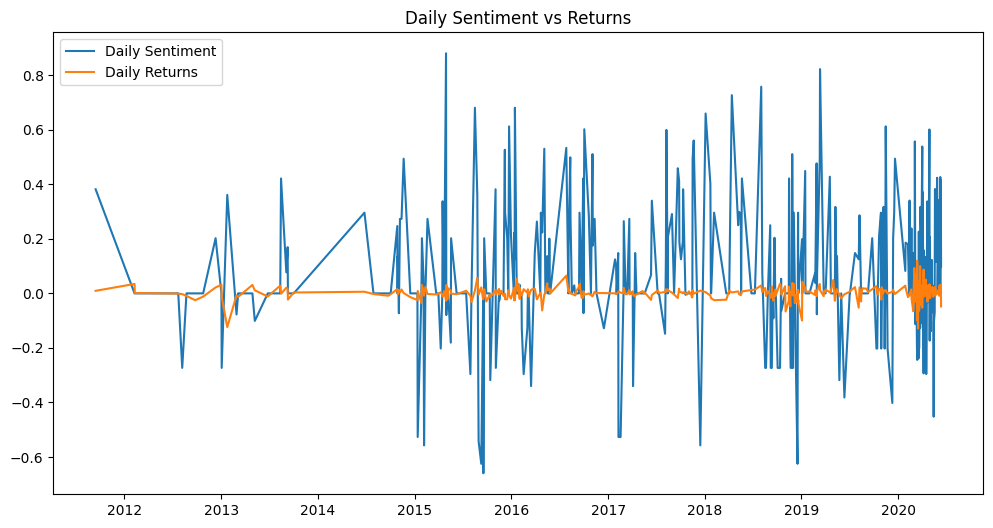

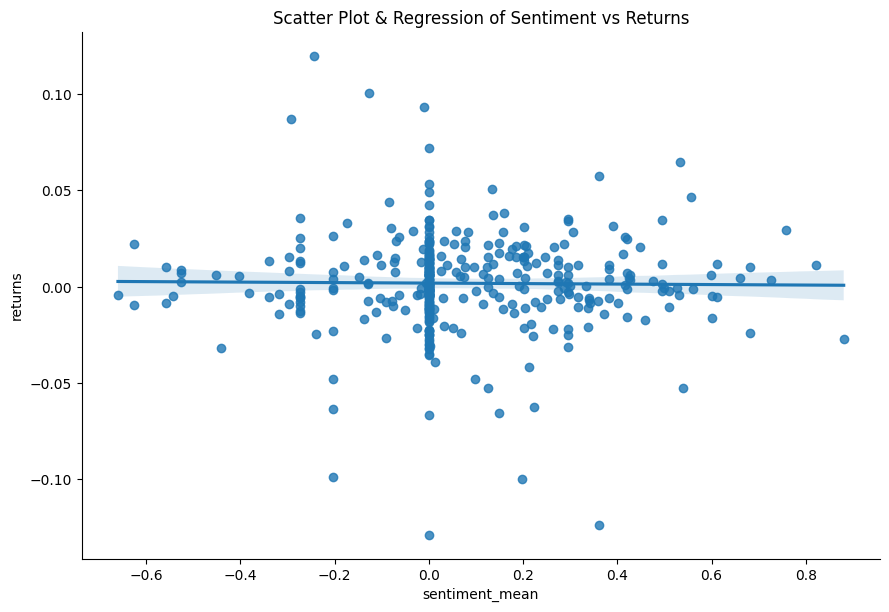

In [5]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Load your datasets
news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')  # must have 'date' and 'headline'
stock_df = pd.read_csv('../data/raw/AAPL.csv')  # must have 'Date' and 'Close'

# Instantiate class
nsc = NewsStockCorrelation(news_df, stock_df, news_date_col='date', stock_date_col='Date')

# Run full pipeline
corr = nsc.run_full_pipeline(headline_col='headline', shift_news_to_next_trading_day=True, sentiment_method='vader')
print("Correlation between daily sentiment and stock returns:", corr)

# View merged DataFrame
print(nsc.merged.head())

# Visualizations
nsc.plot_sentiment_and_returns()
nsc.scatter_and_regression()
